<a href="https://colab.research.google.com/github/Plumz17/PCD_Assignment02/blob/main/PCD_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Second Digital Image Processing Assignment
##Analysis of Image Enhancement Methods - Anders Emmanuel Tan (24/541351/PA/22964)

## 1. Setting Up Image to be Processed

In [76]:
#Cloning Github Repository to get the Image
!rm -rf PCD_Assignment02
!git clone https://github.com/Plumz17/PCD_Assignment02

Cloning into 'PCD_Assignment02'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 1.24 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [77]:
# Import Important Libraries
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import math # For Math

filename_dark = "/content/PCD_Assignment02/dark.jpg"
filename_bright = "/content/PCD_Assignment02/bright.jpg"
filename_low = "/content/PCD_Assignment02/low.png"

img_dark = cv2.imread(filename_dark) # Read Image
img_dark = cv2.cvtColor(img_dark, cv2.COLOR_BGR2RGB) # Change the color map since apparently CV2 defaults on BGR and not RGB'
img_low = cv2.imread(filename_low)
img_low = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)

In [44]:
def show(img): # Helper function to check if image can be processed
  plt.imshow(img)

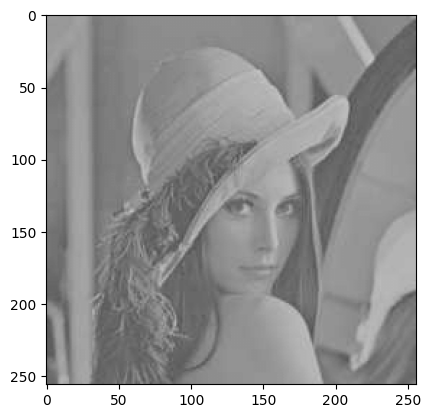

In [78]:
show(img_low) # Citra yang digunakan untuk Downsampling

## 2. Enhancing Dark Images

### 2A. Negative Image

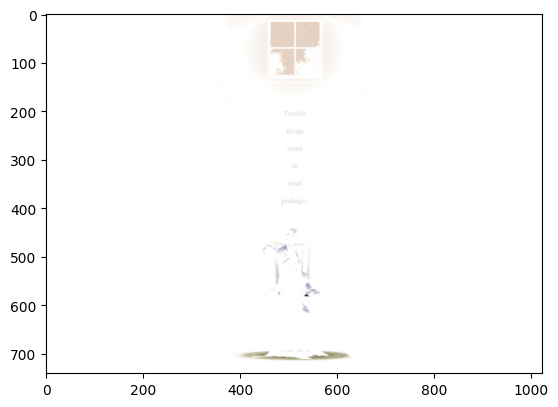

In [46]:
def negative(img):
  out = img.copy()
  L = 256 # max pixel
  for i in range(out.shape[0]): #Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = L - 1 - out[i][j] # Use the formula s = (L - 1) - r, where L is 256 so s = 255 - r
  return out

show(negative(img_dark))

### 2B. Logarithmic Transformation

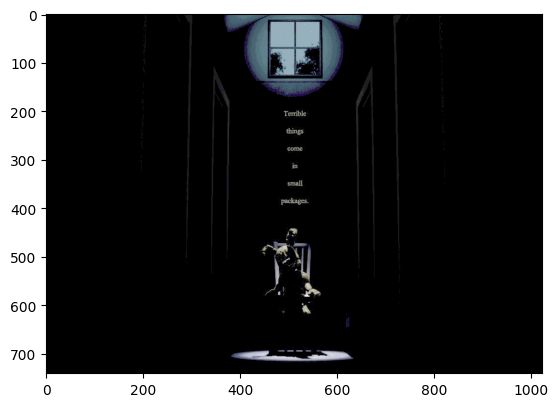

In [58]:
def log(img):
  out = img.copy().astype(float) # So we can handle commas to be log-ed
  R_max = np.max(out)
  L = 256
  c = (L - 1) / np.log(1 + R_max) # Normilize the C to fit (0, 255)
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = c * np.log(1 + out[i][j]) #Use the formula s = c * log(1+r)
  return out.astype(np.uint8)

show(log(img_dark))

### 2C. Gamma Correction

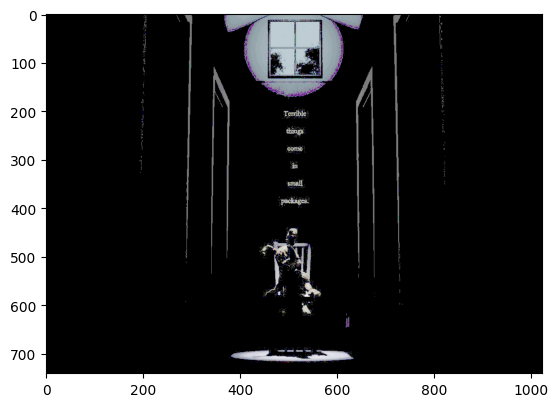

In [61]:
def gamma(img, gamma=1.0):
  out = img.astype(float)
  R_max = np.max(img)
  L = 256
  c = (L - 1) / (R_max ** gamma) # Normilize the C to fit (0, 255)
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = c * (img[i][j] ** gamma) # Use the Formula s = c * r ^ gamma
  return out.astype(np.uint8)

show(gamma(img_dark, 0.5))

## 3. Enhancing Bright Images

## 4. Enhancing Low Contrast Images

###4A. Contrast Stretching


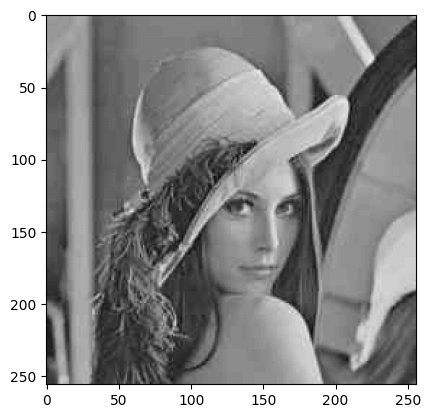

In [81]:
def stretch(img):
  out = img.astype(float)
  # Grab some variables for the formula
  max, min = np.max(out), np.min(out)
  a, b = 0, 255
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = (b - a) * (out[i][j] - min) / (max - min) + a # Apply constrast stretching formula
  return out.astype(np.uint8)

show(stretch(img_low))